**차원의 저주**

고차원의 데이터셋은, 대부분의 훈련 데이터가 서로 멀리 떨어져 있는 매우 희박한 상태에 있다. 예를 들어 3차원 큐브에서 임의의 두 점을 선택하면 평균 거리는 대략 0.66이다. 만약 1,000,000차원의 초 입방체에서 두 점을 무작위로 선택하면 평균 거리는 약 428.25이라고 할 수 있다. 이는 새로운 샘플도 훈련 샘플과 멀리 떨어져 있을 가능성이 높다는 뜻이다. 
- 머신러닝 알고리즘을 일반화시키는데 더 많은 데이터가 필요하게 된다.
- 이 경우 예측을 위해서 훨씬 많은 extrapolation을 해야하기 때문에 저차원일 때보다 예측이 더 불안정하다. 즉 훈련 세트의 차원이 클수록 과대적합 위험이 커진다.

이론적으로 차원의 저주를 해결하는 해결책 중 하나는, 훈련 샘플의 밀도가 충분히 높아질 때까지 훈련 세트의 크기를 키우는 것이다. 불행하게도 실제로 일정 밀도에 도달하기 위해 필요한 훈련 샘플수는 차원 수가 커짐에 따라 기하급수적으로 늘어난다.

(KNN을 활용한 수학적인 설명)
In KNN, we should be able to find a fairly large neighborhood of observations close to any x and average them. This approach and our intuition breaks down in high dimensions. That is, the K observations that are nearest  to a given test observation x0 may be very far away from x0 in p- dimensional space when p is large, leading to a very poor prediction of f(x0) and hence a poor KNN fit.
- Sampling density : The Sampling density is proportional to N1/p, where p is the dimension of the input space and N is the sample size. Thus if N1=100 represents a dense sample for a single input problem, then N10=10010 is the sample size required for the same sampling density with 10 inputs.
- Median distance : The median distance from the origin to the closest data point is given by the expression d(p,N)=(1-1/21/N)1/p. For N=500, p=10, d(p,N)≈0.52, more than halfway to the boundary. Hence most data points are closer to the boundary of the sample space than to any other data point. The reason that this presents a problem is that prediction os much more difficult near the edges of the training sample.
- Overfitting : In general, adding additional signal features that are truly associated with the response will improve the fitted model, in the sense of leading to a reduction in test set error. However, adding noise features that are not truly associated with the response will lead to a deterioration in the fitted model, and consequently an increased test set error. This is because noise features increase the dimensionality of the problem, exacerbating the risk of overfitting without any potential uprise in terms of improved test set error.

실전문제에서 특성 수를 줄여서 불가능한 문제를 가능한 범위로 변경할 수 있는 경우가 많다. 직관적인 예로 MNIST를 생각할 수 있다. 255개의 feature 중 대부분이 흰색이다. 이런 경우는 이런 픽샐을 완전히 제거해도 많은 정보를 잃지 않는다. 인접한 두 픽셀은 종종 많이 연관되어 있다. 따라서 두 픽셀을 하나의 픽셀로 합치더라도 잃는 정보가 많지 않다.

물론(당연히) 차원을 축소시키면 일부 정보가 유실되기는 한다. JPEG로 이미지를 압축하면 품질이 감소되는 것을 생각해보면 된다. 그래서 차원이 줄어들면 훈련 속도가 빨라질 수는 있지만 시스템의 성능이 조금 나빠질 수는 있다. 또한 작업 파이프라인이 조금 더 복잡하게 되고 유지 관리가 어려워진다. 따라서 차원 축소를 고려하기 전에 훈련이 너무 느린지 먼저 원본 데이터로 시스템을 훈련시켜 봐야 한다. 그러나 어떤 경우에는 훈련 데이터의 차원을 축소시키면 잡음이나 불필요한 세부사항을 걸러내므로 성능을 높일 수 있다.(일반적으로는 훈련 속도만 빨라진다.)

# 1. 차원 축소를 위한 접근 방법
- Projection
- Manifold learning

## 1.1 Projection

대부분의 실전문제는 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않다. 많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어 있다. 결과적으로 모든 훈련 샘플이 고차원 공간 안의 저차원 subspace에 가까이 놓여 있다.

In [5]:
# Build 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [12]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

X3D_inv = pca.inverse_transform(X2D)
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [13]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import numpy as np

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [14]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

(-1.0, 1.0)

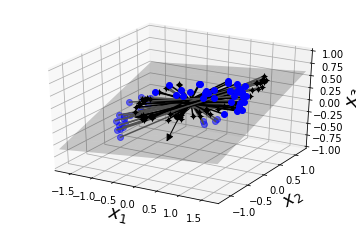

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

모든 훈련 샘플이 거의 평면 형태로 놓여 있음. 이것이 3차원(고차원) 공간에 있는 2차원(저차원) 부분 공간임. 여기서 모든 훈련 샘플을 이 부분 공간에 수직으로(즉, 샘플과 평면 사이의 가장 짧은 직선을 따라) 투영하면 2D 데이터 셋을 얻을 수 있음.

각 축은(평면에 투영된 좌표인 새로운 특성 $z_1$과 $z_2$에 대응됨.

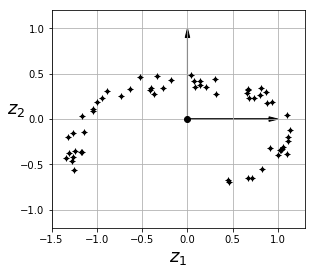

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

## 1.2 Manifold 학습

2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양이다. 일반적으로 $d$차원 매니폴드는 국부적으로 $d$차원 초평면으로 보일 수 있는 $n$차원 공간의 일부이다.$(d < n)$

많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 manifold를 모델링하는 식으로 작동한다. 이를**manifold learning**이라고 한다. 이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정 또는 매니폴드 가설에 근거한다.

간단하게 MNIST dataset으로 생각해보자. 전체 손글씨 숫자 이미지는 어느 정도 비슷한 면이 있다. 선으로 연결되어 있고, 경계는 흰색이고 어느 정도 중앙에 있다. 무작위로 생성된 이미지라면 그 중 아주 적은 일부만 손글씨 숫자처럼 보일 것이다. 다시 말해 숫자 이미지를 만들 때 가능한 자유도는 아무 이미지나 생성할 때의 자유도보다 훨씬 낮다. 이런 제약은 데이터셋을 저차원의 manifold로 압축할 수 있도록 도와준다.

In [18]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

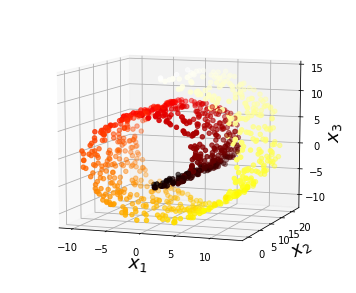

In [19]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

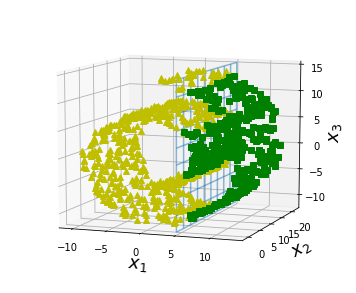

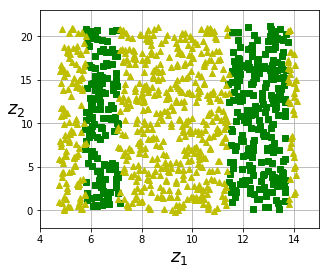

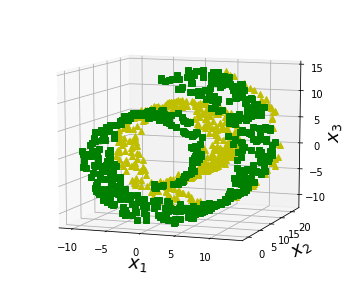

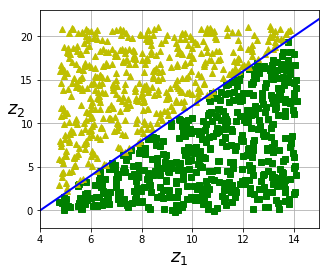

In [20]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

저차원 매니폴드 공간에서 분류, 회귀와 같은 작업을 처리하면 더 간단해질 것이라는 가정이 매니폴드 가정과 함께 병행된다. 4번째 그림을 보면 그것을 뒷받침해준다. 하지만 이런 가정이 언제나 유효하지 않다. 1번째 그림과 2번째 그림을 비교해보면, 2번째보다 1번째일때 경계가 훨씬 더 단순하다.

즉 모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 나은 간단한 솔류션이 되는 것은 아니다. 이것은 전적으로 데이터 셋에 달렸다.

# 2. PCA

PCA(주성분 분석, Principal Component Analysis)는 가장 인기 있는 차원 축소 알고리즘이다. 먼저 데이터에 가장 가까운 초평면(hyperplane)을 정의한 다음, 이 데이터를 이 평면에 투영시킨다.

## 2.1 분산 보존

저차원 초평면에 훈련 세트를 투영하기 전에 먼저 올바른 초평면을 선택해야 한다.

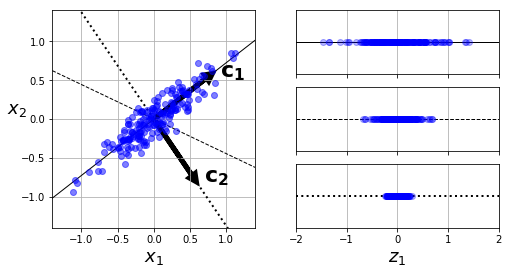

In [21]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

각 축에 투영된 결과가 오른쪽 그림이다. 첫 번째 축(실선 축)이 분산을 최대로 보존하는 반면, 3 번째 축(점선 축)은 분산을 매우 적게 유지하고 있다. 가운데 축은 분산을 중간 정도로 유지하고 있다.

분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적으로 보인다. 이것은 <U>원본 데이터 셋과 투영된 것 사이의 평균 제곱 거리를 최소화 하는 축이다.</U>

## 2.2 SVD를 사용하여 PCA구해보기

### 2.2.1 주성분

PCA는 훈련 세트에서 분산이 최대인 축을 찾습니다. 이 첫 번째 축에 직교하고 남은 분산을 최대한 보존하는 두 번째 축을 찾습니다. 그 다음에는 이전의 두 축에 직교하는 세 번째 축을 찾으며 데이터셋에 있는 차원의 수만큼 네 번째, 다섯 번째,... 축을 찾습니다.

이 때, $i$번째 축을 정의하는 단위 벡터를 $i$번째 **주성분(principal component)**이라고 부릅니다. 

주성분의 방향은 일정하지 않습니다. 훈련 세트를 조금 섞은 다음 다시 PCA를 적용하면 새로운 주성분 중 일부가 원래 주성분과 반대 방향일 수 있습니다. 그러나 일반적으로 같은 축에 놓여 있을 것입니다. 어떤 경우에는 한 쌍의 주성분이 회전하거나 서로 바뀔 수 있지만 보통 같은 평면을 구성합니다.

훈련 세트의 주성분을 찾는 방법은 특잇값 분해(Singular Value Decomposition - SVD)라는 표준 행렬 분해 기술이 있어서 훈련 세트 행렬 $X=U\sum V^T$로 분해할 수 있습니다. 여기서 찾고자 하는 주성분이 $V$에 담겨져 있습니다.

In [38]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [39]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

PCA는 데이터셋의 평균이 0이라고 가정합니다. Sklearn의 PCA 클래스는 이 작업을 대신 처리해줍니다. 하지만 직접 구현한다면 먼제 데이터를 원점에 맞추는 것을 잊어서는 안됩니다.

### 2.2.2 $d$차원으로 투영하기

주성분을 모두 추출해냈다면 처음 $d$개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 $d$차원으로 축소시킬 수 있습니다. 이 초평면은 분산을 가능한 최대로 보존하는 투영임을 보장합니다. 

In [40]:
# 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

# 비교를 위해
X2D_using_svd = X2D

In [41]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

## 2.3 Sklearn을 이용하여 PCA구해보기

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [43]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [44]:
np.allclose(X2D, -X2D_using_svd)

True

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

## 2.4 설명된 분산의 비율

`explained_variance_ratio_` 변수에 저장된 주성분의 설명된 분산의 비율 explained variance ratio 는 유용한 정보 중 하나이다. 이 값은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다.

In [47]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

이것은 데이터 셋 분산의 84.2%가 첫 번째 축에 놓여 있고 14.6%가 두 번째 축에 놓여 있음을 알려준다.

## 2.5 적절한 차원 수 선택하기

축소할 차원 수를 임의로 정하기보다 충반한 분산(예를 들면 95%)이 될 떄까지 더해야 할 차원 수를 선택하는 쪽을 더 선호한다. 데이터를 시각화 하기 위해서는 2개나 3개로 줄이는 것이 일반적이다.

In [50]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [51]:
X_train = np.reshape(x_train, (-1, 784))
X_test = np.reshape(x_test, (-1, 784))

MNIST를 활용하여 차원을 축소해보겠다.

In [52]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [53]:
d

154

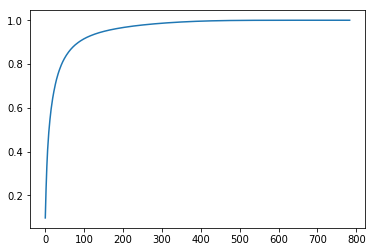

In [57]:
plt.plot(cumsum)

In [54]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [58]:
X_reduced.shape

(60000, 154)

## 2.6 압축을 위한 PCA

MNIST 예제에서 784차원의 특성이 154개로 줄어들었다. 상당합 압축률이며, 분류 알고리즘의 속도를 크게 높일 수 있다. 또한 압축된 데이터셋에서 PCA 투용의 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수도 있다. 물론 투영에서 일정량의 정보(유실된 5%의 분산)을 읽어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없다. 원본 데이터와 재구성된 데이터(압축 후 원복한 것) 사이의 평균 제곱 거리를 재구성 오차(reconstruction error)라고 합니다. 

In [59]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [60]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5,1,'Compressed')

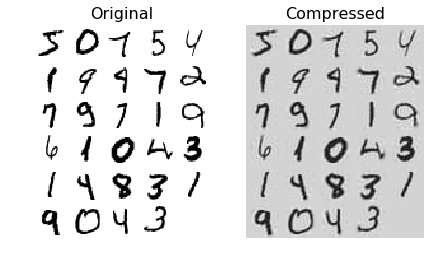

In [62]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

역 변환 공식(원본의 차원 수로 되돌리는 PCA 역반환)
$$X_{\text{recovered}}=X_{d-\text{proj}}W_{d}^{T}$$

## 2.7 점진적 PCA

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것이다. Incremental PCA를 사용하면, 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입한다. 이런 방식은 훈련 세트가 클 때 유용하고 온라인으로(즉, 새로운 데이터가 준비되는 대로 실시간으로) PCA를 적용할 수 있다.

> Numpy로 10개의 batch를 나눈다.

In [63]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

# 100개의 batch를 나누어 학습한다.
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [64]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

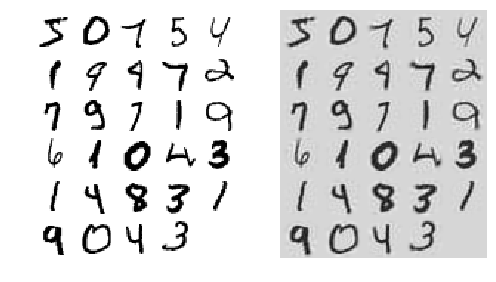

In [65]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

> `memmap`을 이용하여 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것처럼 다룬다.

In [66]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [67]:
del X_mm

In [68]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=600, copy=True, n_components=154, whiten=False)

In [69]:
X_reduced = inc_pca.transform(X_train)

In [70]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

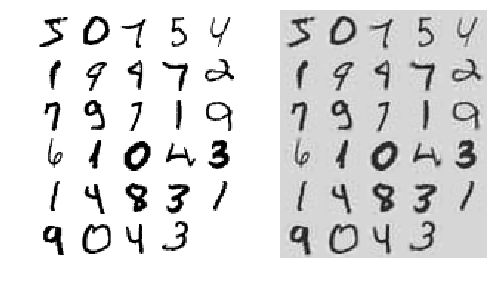

In [71]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

## 2.8 Rabdom PCA
확률적인 알고리즘으로, 첫 $d$개의 주성분에 대한 근사값을 빠르게 찾습니다. 이 알고리즘은 $O(m \times n^2)+O(n^3)$이 아니라 $O(m \times d^2)+O(d^3)$입니다. 그래서 $d$가 $n$보다 많이 작으면 앞선 알고리즘보다 매우 빨라집니다.

In [72]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [73]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 3.3 seconds
    IncrementalPCA: 14.9 seconds
    PCA: 2.4 seconds
n_components = 10
    PCA: 3.1 seconds
    IncrementalPCA: 17.0 seconds
    PCA: 3.0 seconds
n_components = 154
    PCA: 6.9 seconds
    IncrementalPCA: 23.9 seconds
    PCA: 5.6 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

In [ ]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

In [ ]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# 3. Kernel PCA

커널 트릭은 샘플을 매우 높은 고차원 공간(특성 공간, feature space)으로 암묵적으로 매핑하여 서포트 벡터 머신의 비선형 분류와 회귀를 가능하게 하는 수학적인 기법이다. 고차원 특성 공간에서의 선형 결정 경계는 원본 공간에서는 복잡한 비선형 결정 경계에 해당한다.

같은 기법을 PCA에 적용해 복잡한 비선형 투영으로의 차원 축소를 가능하게 할 수 있다. 이것을 커널 PCA(Kernel PCA)라고 한다. 이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때도 유용하다.

In [75]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [76]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

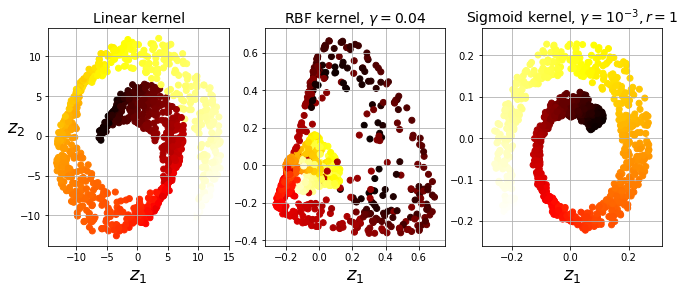

In [77]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

## 3.1 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없다. 하지만 차원 축소는 종종 지도 학습(예를 들면 분류)의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있다.

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

# 4. LLE

Locally Linear Embeddding(LLE)는 또 다른 강력한 비선형 차원 축소(nonlinear dimensionality reduction) 기술이다. 투영에 의존하지 않는 manifold learning이다.

LLE는 먼저 각 훈련 샘플이 가장 가까운 이웃(closest neighbor)에 얼마나 선형적으로 연관되어 있는지 측정한다. 그런 다음 국부적인 관계가 잘 보존되는 훈련 세트의 저차원 표현을 찾는다. 이는 특히 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는 데 잘 작동한다.

In [80]:
# 스위스 롤을 펼치는 코드
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [81]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

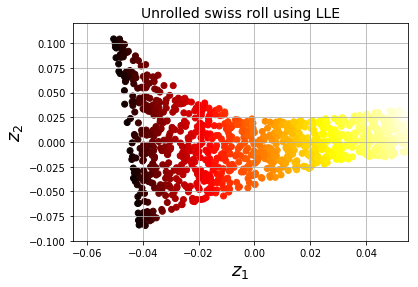

In [82]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

(LLE 작동하는 방식)
먼저 알고리즘이 각 훈련 샘플 $x^{(i)}$에 대해 가장 가까운 $k$개의 샘플을 찾는다. 그런 다음 이 이웃에 대한 선형 함수로 $x^{(i)}$를 재구성한다. 더 구체적으로 말하면 $x^{(i)}$와 $\sum_{j=1}^{m}w_{i,j}x^{(i)}$ 사이의 제곱 거리가 최소가 되는 $w_{i,j}$를 찾는다. 여기서 $x^{(j)}$가 $x^{(i)}$의 가장 가까운 $k$개 이웃 중 하나가 아닐 경우에는 $w_{i,j}=0$이 된다. 따라서 LLE의 첫 단계는 제한이 있는 최적화 문제가 된다.
$$\hat{W}=\arg \max_{w} \sum_{i=1}^{m}(x^{(i)} - \sum_{j=1}^{m}w_{i,j}x^{(j)})^2$$

(조건)

$x^{(j)}$가 $x^{(i)}$의 최근접 이웃 $k$개 중 하나가 아닐 때 : $w_{i, j}=0$

$i=1,2,...,m$ 일 때 : $\sum_{j=1}^{m}w_{i,j}=1$

이 단계를 거치면 (가중치 $\hat{w}_{i,j}$를 담고 있는) 가중치 행렬 $\hat{W}$은 훈련 샘플 사이에 있는 지역 선형 관계를 담고 있다. 이제 두 번째 단계는 가능한 한 이 관계가 보존되도록 훈련 샘플을 $d$차원 공간$(d<n)$으로 매핑합니다. 만약 $z^{(i)}$가 $d$차원 공간에서 $x^{(i)}$의 상이라면 가능한 한 $z^{(i)}$와 $\sum_{j=1}^{m}\hat{w}_{i,j}z^{j}$ 사이의 거리가 최소화되어야 한다. 따라서 제약이 없는 최적화 문제로 바뀐다.

$$\hat{Z}=\arg \max_{z} \sum_{i=1}^{m}(z^{(i)} - \sum_{j=1}^{m}w_{i,j}z^{(j)})^2$$

샘플을 고정하고 최적의 가중치를 찾는 대신, 반대로 가중치를 고정하고 저차원의 공간에서 샘플 이지미의 최적 위치를 찾는다.

Sklearn이 제공하는 LLE 구현의 계산 복잡도는 $k$개의 가장 가까운 이웃을 찾는 데 $O(m\log(m)n \log(k))$, 가중치 최적화에 $O(mnk^3)$, 저차원 표현을 만드는 데 $O(dm^2)$이다. 마지막항의 $m^2$ 때문에 이 알고리즘을 대량의 데이터셋에 적용하기는 어렵다.

# 5. 다른 차원 축소 기법
- Multidimensional Scaling(다차원 스케일링)은 샘플 간의 거리를 보존하면서 차원을 축소한다.
- Isomap은 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만든다. 그런 다음 샘플 간의 geodesic distance를 유지하면서 차원을 축소한다. Geodesic distance는 두 노드 사이의 최단 경로를 이루는 노드의 수이다.
- t-SNE (t-Distributed Stochastic Neighbor Embedding)은 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소한다. 주로 시각화에 많이 사용되며 특히 고차원에 있는 샘플의 군집을 시각화할 때 사용된다.
- Linear Discriminant Analysis(LDA)는 사실 분류 알고리즘이다. 하지만 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습한다. 이 축은 데이터가 투영되는 초평면을 정의하는데 사용할 수 있다. 이 알고리즘의 장점은 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM 분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소시키는데 좋다.

In [84]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [85]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [86]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

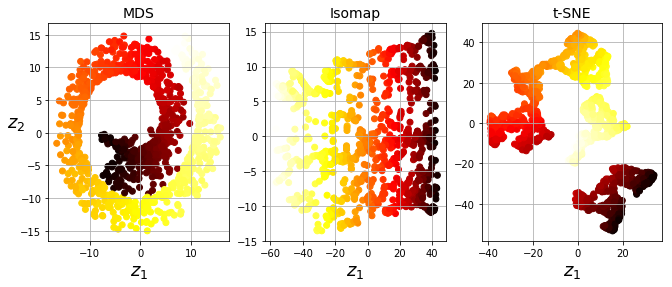

In [88]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)